<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/pR50_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_model_optimization

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import os
import tracemalloc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Define paths
train_dir = '/content/drive/MyDrive/motor_data/train'
validation_dir = '/content/drive/MyDrive/motor_data/validation'
test_dir = '/content/drive/MyDrive/motor_data/test'

# Set image size and batch size
image_size = (224, 224)
batch_size = 32

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
validation_dataset = image_dataset_from_directory(validation_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
test_dataset = image_dataset_from_directory(test_dir, image_size=image_size, batch_size=batch_size, label_mode='int')

Found 12004 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4004 files belonging to 4 classes.


In [ ]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: normal, fault_BB, fault_SM, fault_RI
])

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 4332s 11s/step - loss: 0.1111 - accuracy: 0.9858 - val_loss: 1.1682 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 262s 683ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 24.8174 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 262s 684ms/step - loss: 0.0273 - accuracy: 0.9940 - val_loss: 9.7571e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 257s 670ms/step - loss: 3.3798e-04 - accuracy: 0.9999 - val_loss: 2.1457e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 256s 671ms/step - loss: 5.6785e-04 - accuracy: 0.9999 - val_loss: 2.7358e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 255s 671ms/step - loss: 1.7014e-05 - accuracy: 1.0000 - val_loss: 1.7047e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376

In [ ]:
# Initial evaluation
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Initial Validation Loss: {val_loss}")
print(f"Initial Validation Accuracy: {val_acc}")

125/125 [==============================] - 56s 428ms/step - loss: 0.0016 - accuracy: 0.9995
Initial Validation Loss: 0.0015830086776986718
Initial Validation Accuracy: 0.9994999766349792


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Initial Test Loss: {test_loss}")
print(f"Initial Test Accuracy: {test_acc}")

126/126 [==============================] - 1199s 9s/step - loss: 0.0015 - accuracy: 0.9998
Initial Test Loss: 0.0014547008322551847
Initial Test Accuracy: 0.9997502565383911


In [ ]:
# Save initial model and measure size
model.save('original_motor_fault_classification_model.h5')
original_model_size = os.path.getsize('original_motor_fault_classification_model.h5')
print(f"Original Model Size: {original_model_size / (1024 * 1024):.2f} MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Original Model Size: 282.31 MB


In [ ]:
# Measure initial inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true, y_pred = [], []
for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
original_inference_time = end_time - start_time
original_peak_memory = peak / (1024 * 1024)
print(f"Original Inference Time: {original_inference_time:.2f} seconds")
print(f"Original Peak Memory Usage: {original_peak_memory:.2f} MB")

1/1 [==============================] - 3s 3s/step
Original Inference Time: 81.92 seconds
Original Peak Memory Usage: 5.83 MB


In [ ]:
# Initial model evaluation metrics
conf_matrix_original = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Original):")
print(conf_matrix_original)

print("Classification Report (Original):")
print(classification_report(y_true, y_pred, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Original):
[[1003    0    0    1]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
Classification Report (Original):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



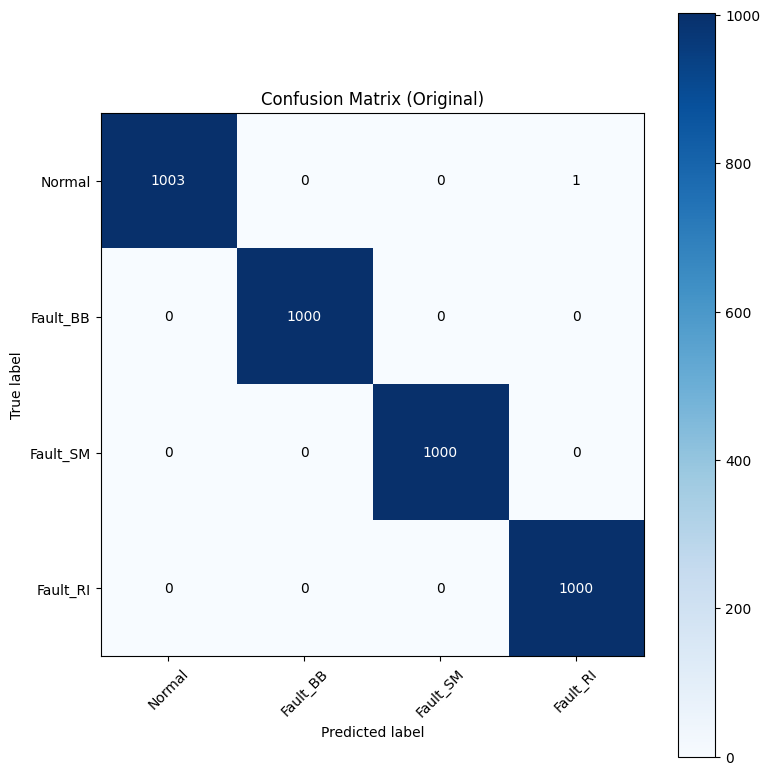

In [ ]:
# Visualize initial confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Original)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_original.max() / 2.
for i, j in np.ndindex(conf_matrix_original.shape):
    plt.text(j, i, format(conf_matrix_original[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_original[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate additional initial metrics
f1_original = f1_score(y_true, y_pred, average='weighted')
precision_original = precision_score(y_true, y_pred, average='weighted')
recall_original = recall_score(y_true, y_pred, average='weighted')

In [ ]:
print(f"Original F1 Score: {f1_original:.2f}")
print(f"Original Precision: {precision_original:.2f}")
print(f"Original Recall: {recall_original:.2f}")

Original F1 Score: 1.00
Original Precision: 1.00
Original Recall: 1.00


In [ ]:
# Structured Pruning 적용
def apply_structured_pruning(model, pruning_percentage=70):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            num_filters = weights.shape[-1]
            num_prune = int(num_filters * pruning_percentage / 100)

            # Compute the L1 norm of the filters
            filter_norms = np.sum(np.abs(weights), axis=(0, 1, 2))
            prune_indices = np.argsort(filter_norms)[:num_prune]

            # Set the weights of the pruned filters to zero
            for idx in prune_indices:
                weights[:, :, :, idx] = 0

            layer.set_weights([weights, biases])

apply_structured_pruning(model, pruning_percentage=70)

# Recompile pruned model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train pruned model
history_pruned = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 322s 754ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 1.6627e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 284s 746ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 7.1695e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 255s 671ms/step - loss: 0.0212 - accuracy: 0.9958 - val_loss: 6.9849 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 255s 670ms/step - loss: 0.0817 - accuracy: 0.9968 - val_loss: 1.6966e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 261s 681ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 5.5052e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 282s 741ms/step - loss: 0.0111 - accuracy: 0.9998 - val_loss: 9.0763e-04 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 7/10
376/376 [======

In [ ]:
# Evaluate pruned model
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Pruned Validation Loss: {val_loss}")
print(f"Pruned Validation Accuracy: {val_acc}")

125/125 [==============================] - 55s 418ms/step - loss: 2.1809e-04 - accuracy: 1.0000
Pruned Validation Loss: 0.00021808886958751827
Pruned Validation Accuracy: 1.0


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Pruned Test Loss: {test_loss}")
print(f"Pruned Test Accuracy: {test_acc}")

126/126 [==============================] - 56s 409ms/step - loss: 6.0746e-05 - accuracy: 1.0000
Pruned Test Loss: 6.074616248952225e-05
Pruned Test Accuracy: 1.0


In [ ]:
# Strip pruning wrappers and prepare model for QAT
model_for_qat = tfmot.sparsity.keras.strip_pruning(model)

# Apply quantization aware training
quantize_model = tfmot.quantization.keras.quantize_model
qat_model = quantize_model(model_for_qat)

# Recompile QAT model
qat_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

ValueError: ('Expected model to be a `keras.Model` instance but got: ', <keras.src.engine.sequential.Sequential object at 0x7b3f445622c0>)

In [ ]:
# Train QAT model
history_qat = qat_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

In [ ]:
# Evaluate QAT model
val_loss, val_acc = qat_model.evaluate(validation_dataset)
print(f"QAT Validation Loss: {val_loss}")
print(f"QAT Validation Accuracy: {val_acc}")

In [ ]:
test_loss, test_acc = qat_model.evaluate(test_dataset)
print(f"QAT Test Loss: {test_loss}")
print(f"QAT Test Accuracy: {test_acc}")

In [ ]:
# Convert to TensorFlow Lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
# Save the TFLite model
with open('quantized_motor_fault_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
tflite_model_size = os.path.getsize('quantized_motor_fault_classification_model.tflite')
print(f"TFLite Model Size: {tflite_model_size / (1024 * 1024):.2f} MB")

In [ ]:
# Measure TFLite model inference time and memory usage
interpreter = tf.lite.Interpreter(model_path='quantized_motor_fault_classification_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Preprocess input
def preprocess_image(image):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1]
    return image

start_time = time.time()
tracemalloc.start()
y_true_tflite, y_pred_tflite = [], []
for batch in test_dataset:
    images, labels = batch
    y_true_tflite.extend(labels.numpy())
    for image in images:
        preprocessed_image = preprocess_image(image).numpy()
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_tflite.append(np.argmax(output_data))

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
tflite_inference_time = end_time - start_time
tflite_peak_memory = peak / (1024 * 1024)
print(f"TFLite Inference Time: {tflite_inference_time:.2f} seconds")
print(f"TFLite Peak Memory Usage: {tflite_peak_memory:.2f} MB")

In [ ]:
# TFLite model evaluation metrics
conf_matrix_tflite = confusion_matrix(y_true_tflite, y_pred_tflite)
print("Confusion Matrix (TFLite):")
print(conf_matrix_tflite)

print("Classification Report (TFLite):")
print(classification_report(y_true_tflite, y_pred_tflite, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

In [ ]:
# Visualize TFLite confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_tflite, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (TFLite)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_tflite.max() / 2.
for i, j in np.ndindex(conf_matrix_tflite.shape):
    plt.text(j, i, format(conf_matrix_tflite[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_tflite[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate additional TFLite metrics
f1_tflite = f1_score(y_true_tflite, y_pred_tflite, average='weighted')
precision_tflite = precision_score(y_true_tflite, y_pred_tflite, average='weighted')
recall_tflite = recall_score(y_true_tflite, y_pred_tflite, average='weighted')

print(f"TFLite F1 Score: {f1_tflite:.2f}")
print(f"TFLite Precision: {precision_tflite:.2f}")
print(f"TFLite Recall: {recall_tflite:.2f}")